In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.stats import circmean, circstd, mode

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
import taylorDiagram

from numpy.fft import fft, ifft
import astropy.stats.circstats as astro_circstats

import diurnal_config

from diurnal_utils import *
from fetch_model_helper import *
import dask.dataframe as dd

%run cmip_metrics.py
%run model_by_model_analysis_helper.py

import matplotlib 

font = {'weight' : 'bold',
        'size'   : 13}
label_fontdict = {'weight' : 'bold',
        'size'   : 13}
title_fontdict = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

FLUX_TO_MM_HR = 60*60
MM_HR_TO_MM_YR = 24*365
FLUX_TO_MM_YR = FLUX_TO_MM_HR*MM_HR_TO_MM_YR

HOURS_TO_RADIANS = 2*np.pi/24


In [11]:
rel_data_dir = '/export/data1/cchristo/'
save_figs_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/'
save_figs_dir_paper = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/paper/'

##### open cmip5
# input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5_regridded/grid1/' #GFDL-ESM2M/'
input_data_dir_cm5  = rel_data_dir + 'diurnal_analysis_results/CMIP5_bin_pt2_hr_round_regridded/grid1/'

#### open cmip6
# input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_regridded/grid1/' #GFDL-ESM4/'
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_bin_pt2_hr_round_regridded/grid1/' #GFDL-ESM4/'
# input_data_dir_cm6 = rel_data_dir + 'diurnal_analysis_results/CMIP6_clt_regridded/grid1/'

input_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results//GPM_bin_pt2_hr_15_yr_regridded/grid1/GPM_bin_pt2_hr_15_yr/'
land_sea_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/grid1/grid1_GLDASp4_landmask_1d.nc'


# paths to mean climate fields 



input_data_dir_rlut = rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/'
input_data_dir_rsut = rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/' 
input_data_dir_pr = rel_data_dir + 'CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/'
input_data_dir_clt = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/' 
input_data_dir_cltl = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/cltl_regridded/grid1/' 
input_data_dir_clth = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clth_regridded/grid1/' 
mean_fields_to_rel_path_map = {
    'rlut': input_data_dir_rlut,
    'rsut': input_data_dir_rsut,
    'pr': input_data_dir_pr,
    'clt':input_data_dir_clt,
    'cltl': input_data_dir_cltl,
    'clth': input_data_dir_clth,
}



In [3]:
rel_cmip6_path= '/export/data1/cchristo/CMIP6_clouds/clt_3hr_historical/'
rel_cmip5_path = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'

unique_cmip6_models = list(get_unique_models(rel_cmip6_path))
unique_cmip5_models = list(get_unique_models(rel_cmip5_path))

In [4]:

ds_land_sea = xr.open_dataset(land_sea_mask)
df_land_sea = ds_land_sea.to_dataframe().astype(int)
# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']




## Take mean accross seasons for GPM (circular for phase!)

In [76]:
# ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2016-06_precip.nc')

# ### compute means
# # # take mean across seasons using circular mean for phase
# ds_gpm_phase_year_mean = xr.apply_ufunc(phase_circmean, ds_gpm['phase_season'], 
# #                                    kwargs = {'low' : 0.0, 'high' : 24.0},
#                                    input_core_dims=[["season"]], 
#                                    vectorize = True)
# # compute yearly mean other data 
# ds_gpm = ds_gpm.mean(dim = 'season')
# ds_gpm['phase_season'] = ds_gpm_phase_year_mean

# #########

# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
# df_gpm = ds_gpm.to_dataframe()

# df_gpm_land = df_gpm[df_gpm['land_sea_mask'] == 1]
# df_gpm_water= df_gpm[df_gpm['land_sea_mask'] == 0]

In [99]:
ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2016-06_precip.nc')

### compute means
# # take mean across seasons using circular mean for phase
ds_gpm_phase_year_mean = xr.apply_ufunc(phase_circmean, ds_gpm['phase_season'], 
#                                    kwargs = {'low' : 0.0, 'high' : 24.0},
                                   input_core_dims=[["season"]], 
                                   vectorize = True)
# compute yearly mean other data 
ds_gpm = ds_gpm.mean(dim = 'season')
ds_gpm['phase_season'] = ds_gpm_phase_year_mean

#########

ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
df_gpm = ds_gpm.to_dataframe()

In [5]:
%run model_by_model_analysis_helper.py

df_gpm_seasonal = _open_and_preprocess_gpm(input_data_dir_gpm, ds_land_sea, False)
df_gpm = _open_and_preprocess_gpm(input_data_dir_gpm, ds_land_sea, True)



In [6]:
%%time
# # compute yearly mean
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = True,
                               verbose = False)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = 'grid1_1985-01_2006-01_precip.nc', 
                              compute_year_mean_bool = True,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,) #.reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df = pd.merge(df_models, df_land_sea, how = 'left', left_index = True, right_index = True)
# df = df.reset_index('season')
df = df.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

CPU times: user 7min 2s, sys: 7.25 s, total: 7min 9s
Wall time: 7min 20s


In [256]:
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = False,
                               verbose = False)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = 'grid1_1985-01_2006-01_precip.nc', 
                              compute_year_mean_bool = False,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,).reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df_seasonal = pd.merge(df_models, 
                       df_land_sea, 
                       how = 'left', 
                       left_index = True, 
                       right_index = True)
# df_seasonal = df_seasonal.reset_index('season')
df_seasonal = df_seasonal.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

In [80]:
# plt.savefig(‘test.pdf’, bbox_inches=‘tight’)

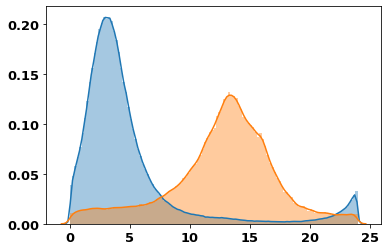

In [79]:
cmip_identifier = 'CMIP6'
field_id = 'phase_season'
nbins = 120
ax = None

df_water = df[(df['land_sea_mask'] == 0) & (df['cmip_identifier'] == cmip_identifier)] #[field_id]
df_land = df[(df['land_sea_mask'] == 1) & (df['cmip_identifier'] == cmip_identifier)] #[field_id]



sns.distplot(df_water[field_id].values , label = cmip_identifier + ' ' + 'Water', bins = nbins, ax = ax)
sns.distplot(df_land[field_id].values , label = cmip_identifier + ' ' + 'Land', bins = nbins, ax = ax)



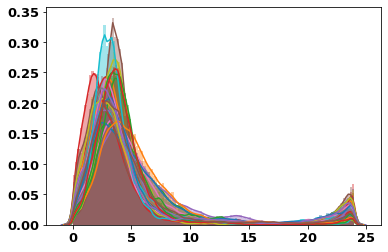

In [71]:
for model_name in df_water['model_name'].unique():
    sns.distplot(df_water[df_water['model_name'] == model_name][field_id].values , 
                 bins = nbins, 
                 ax = ax)



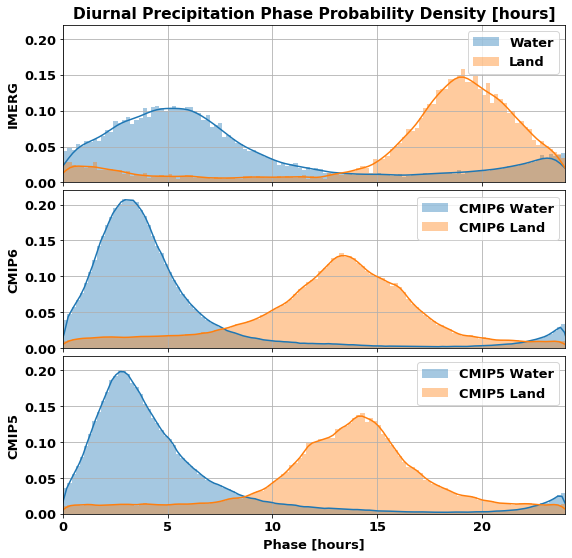

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [51]:
%run model_by_model_analysis_helper.py

fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))

land_sea_histogram(df_gpm, 
                   ax = ax_hist[0],
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG')

land_sea_histogram(df,
                   cmip_identifier= 'CMIP6',
                   ax = ax_hist[1],
                   ylabel = 'CMIP6')

land_sea_histogram(df,
                   cmip_identifier = 'CMIP5',
                   ax = ax_hist[2],
                   ylabel = 'CMIP5',
                   xlabel = 'Phase [Hour]')

fig.subplots_adjust(hspace=.05)

# fig.savefig(save_figs_dir_paper + 'yearly_histogram.png', dpi = 300)



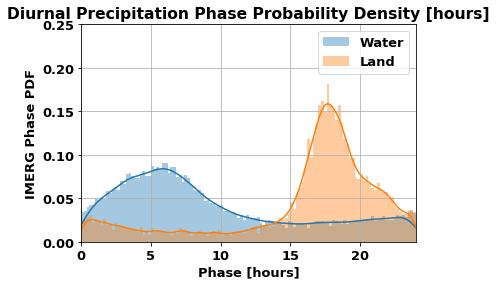

In [261]:
land_sea_histogram(filter_by_season(df_gpm, season_ii), 
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG Phase PDF')

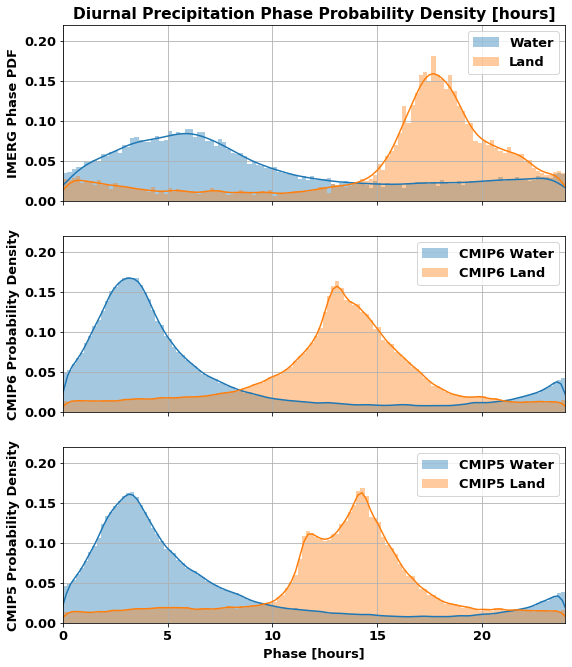

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [262]:
# land_sea_histogram(filter_by_season(df, 'JJA'), nbins = 50)
# land_sea_histogram(df_gpm, field_id = 'ampl_season', nbins = 30)



fig, ax_hist_season = plt.subplots(3, 1, sharex = True, figsize = (9,11))

season_ii = 'JJA'

land_sea_histogram(filter_by_season(df_gpm, season_ii), 
                   ax = ax_hist_season[0],
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG Phase PDF')

land_sea_histogram(filter_by_season(df, season_ii),
                   cmip_identifier= 'CMIP6',
                   ax = ax_hist_season[1],
                   ylabel = 'CMIP6 Probability Density')

land_sea_histogram(filter_by_season(df, season_ii),
                   cmip_identifier = 'CMIP5',
                   ax = ax_hist_season[2],
                   ylabel = 'CMIP5 Probability Density',
                   xlabel = 'Phase [Hour]')

# fig.subplots_adjust(hspace=.05)

In [28]:
# make_four_panel(ds , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0, vmax = 24, 
#                 cmap = plt.get_cmap('twilight'),
#                 title = r'$\Phi$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= None)

# compute error statistics


In [14]:
df_cmip6 = df[df['cmip_identifier'] == 'CMIP6']
df_cmip5 = df[df['cmip_identifier'] == 'CMIP5']

# df_cmip6_seasonal = df_seasonal[df_seasonal['cmip_identifier'] == 'CMIP6']
# df_cmip5_seasonal = df_seasonal[df_seasonal['cmip_identifier'] == 'CMIP5']


field = 'phase_season'
# season = 'DJF'
# df

df_for_stats = df_cmip6.copy()
df_for_stats_true = df_gpm.copy()

df_for_stats['ampl_season'] = FLUX_TO_MM_HR*df_for_stats['ampl_season']
df_for_stats['mu_season'] = FLUX_TO_MM_HR*df_for_stats['mu_season']
# df_for_stats = df_for_stats[df_for_stats['season'] == season]

df_for_stats_cmip5, df_for_stats_cmip6 = df_cmip5.copy(), df_cmip6.copy()
df_for_stats_cmip5['ampl_season'] = FLUX_TO_MM_HR*df_for_stats_cmip5['ampl_season']
df_for_stats_cmip6['ampl_season'] = FLUX_TO_MM_HR*df_for_stats_cmip6['ampl_season']

df_for_stats_land = df_for_stats[df_for_stats['land_sea_mask'] == 1]
df_for_stats_water = df_for_stats[df_for_stats['land_sea_mask'] == 0]

df_for_stats_true_land = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 1]
df_for_stats_true_water = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 0]



In [86]:
# df_for_stats_true = df_gpm[df_gpm['season'] == season]

# # compute precip weights
# df_for_stats_true['precip_weights'] = df_for_stats_true['mu_season']/df_for_stats_true['mu_season'].sum()

# # merge gpm precip weights into model df 
# df_for_stats = pd.merge(df_for_stats, 
#                         df_for_stats_true['precip_weights'], 
#                         how = 'left', 
#                         left_index = True, 
#                         right_index = True)


df_lat_lon_mean = df_for_stats.groupby(['lat','lon']).mean()
# df_lat_lon_mode_phase = df_for_stats.round(1).groupby(['lat','lon'])['phase_season'].agg(mode_apply)
# df_lat_lon_mode_ampl = df_for_stats.round(4).groupby(['lat','lon'])['ampl_season'].agg(mode_apply)

# df_lat_lon_err = df_lat_lon_mean - df_for_stats_true
df_lat_lon_err = circdiff(df_lat_lon_mean, df_for_stats_true)
cmips_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err)
cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)
# cmips_mode_df = pd.DataFrame()
# cmips_mode_df['phase_mode'] = df_lat_lon_mode_phase
# cmips_mode_df['ampl_mode'] = df_lat_lon_mode_ampl
# cmips_mode_ds = xr.Dataset.from_dataframe(cmips_mode_df)

# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'precip_weights', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

df_lat_lon_mean_cmip5 = df_for_stats_cmip5.groupby(['lat','lon']).mean()
cmip5_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean_cmip5)


df_lat_lon_mean_cmip6 = df_for_stats_cmip6.groupby(['lat','lon']).mean()
cmip6_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean_cmip6)




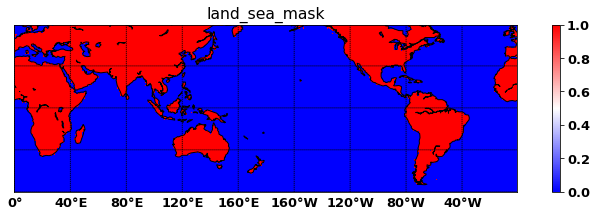

In [19]:
make_single_plot(ds_land_sea['GLDAS_mask'] ,
                 title = 'land_sea_mask',
                 vmin = 0, vmax = 1, 
                 cmap  =plt.get_cmap('bwr'))



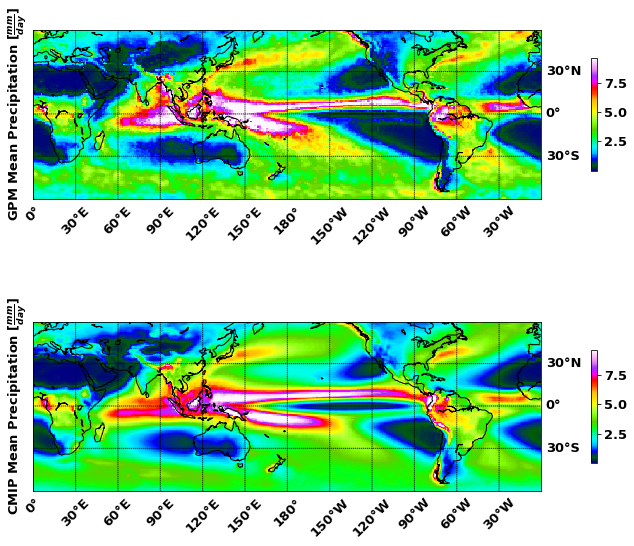

In [326]:


fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,9))


# make_single_plot(ds_gpm['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase [hours]',
#                  ax = ax_hist[0],
#                  fig = fig,
#                  ylabel = 'IMERG', 
#                  xticks_bool = False,
#                  cmap = plt.get_cmap('twilight_shifted'),
#                  vmin = 0, vmax = 24)





make_single_plot(ds_gpm['mu_season']*24, 
                 ax = ax_hist[0],
                 title = None,
                 fig = fig,
                 ylabel = r'GPM Mean Precipitation [$\frac{mm}{day}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
make_single_plot(cmips_mean_ds['mu_season'] *24, 
                 ax = ax_hist[1],
                 title = None,
                 fig = fig,
                 ylabel = r'CMIP Mean Precipitation [$\frac{mm}{day}$]',
                cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24)
plt.savefig(save_figs_dir + 'tapio_update_8_26/' + 'mu_mean_spatial.png', dpi = 300)

# make_single_plot(cmips_mean_ds['mu_season'].where(cmips_mean_ds['mu_season'] > 0.04), 
#                  title = r'CMIP Mean Precipitation [$\frac{mm}{yr}$]',
#                   cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

In [112]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.00112189)

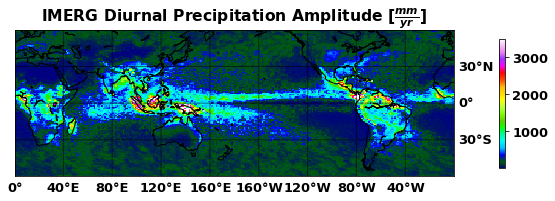

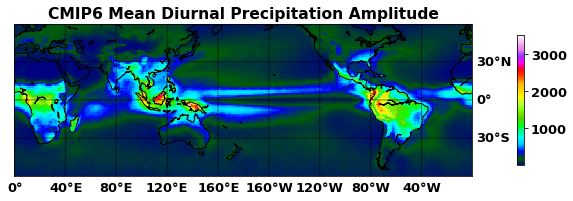

In [257]:
make_single_plot(ds_gpm['ampl_season']*MM_HR_TO_MM_YR, 
                 title = r'IMERG Diurnal Precipitation Amplitude [$\frac{mm}{yr}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*MM_HR_TO_MM_YR)
# plt.savefig(save_figs_dir + 'GPM/' + 'ampl_mean_spatial.png', dpi = 300)

make_single_plot(cmip6_mean_ds['ampl_season']*MM_HR_TO_MM_YR, 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*MM_HR_TO_MM_YR)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'ampl_mean_spatial.png', dpi = 300)

In [254]:
cmip6_mean_ds['ampl_season']

<xarray.DataArray 'ampl_season' (lat: 240, lon: 720)>
array([[1.77424907e-06, 1.77404718e-06, 1.84004412e-06, ...,
        1.82657440e-06, 1.80053514e-06, 1.77874803e-06],
       [1.78115941e-06, 1.78492269e-06, 1.85814124e-06, ...,
        1.83049625e-06, 1.80570691e-06, 1.78391980e-06],
       [1.78255370e-06, 1.78631697e-06, 1.85379687e-06, ...,
        1.83571705e-06, 1.81092772e-06, 1.78531409e-06],
       ...,
       [2.59111304e-06, 2.63660300e-06, 2.68212917e-06, ...,
        2.23492876e-06, 2.34699876e-06, 2.56657805e-06],
       [2.59310149e-06, 2.54652297e-06, 2.54798813e-06, ...,
        2.43032057e-06, 2.47792103e-06, 2.57486606e-06],
       [2.60444531e-06, 2.55786679e-06, 2.55200124e-06, ...,
        2.42137776e-06, 2.46897822e-06, 2.58620988e-06]])
Coordinates:
  * lat      (lat) float64 -60.0 -59.5 -59.0 -58.5 -58.0 ... 58.0 58.5 59.0 59.5
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5

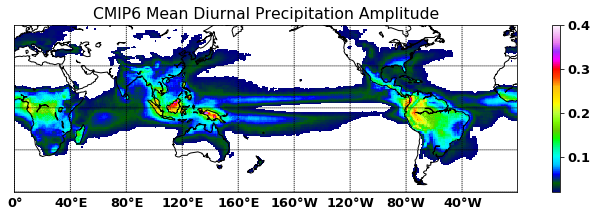

In [108]:
make_single_plot(cmips_mean_ds['ampl_season'].where(cmips_mean_ds['ampl_season']> 0.02), 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

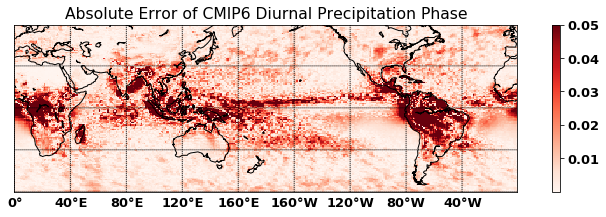

In [109]:
make_single_plot(cmips_err_ds['ampl_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'),vmax = 0.05)
# plt.savefig(save_figs_dir + 'compare_models/' + 'ampl_abs_error_spatial.png', dpi = 300)

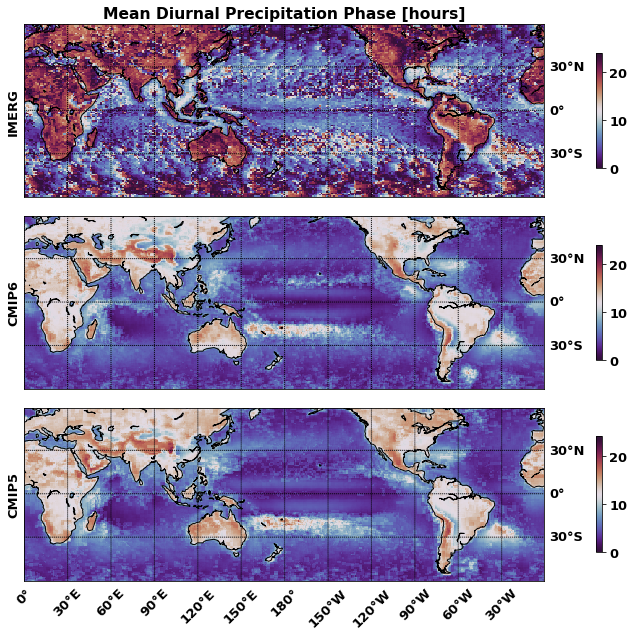

In [281]:
%run diurnal_utils.py


fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))


make_single_plot(ds_gpm['phase_season'], 
                 title = r'Mean Diurnal Precipitation Phase [hours]',
                 ax = ax_hist[0],
                 fig = fig,
                 ylabel = 'IMERG', 
                 xticks_bool = False,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

make_single_plot(cmip6_mean_ds['phase_season'], 
#                  title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 title = None,
                 ax = ax_hist[1],
                 fig = fig,
                 ylabel = 'CMIP6',
                 xticks_bool = False,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

make_single_plot(cmip5_mean_ds['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
                 ax = ax_hist[2],
                 fig = fig,
                 ylabel = 'CMIP5',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)




fig.subplots_adjust(hspace=.01)
fig.savefig(save_figs_dir_paper + 'phase_mean_spatial_yearly.png', dpi = 300)



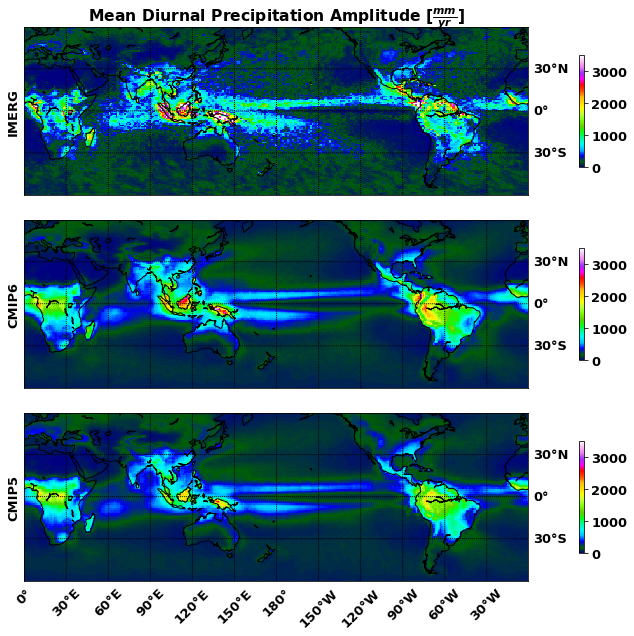

In [282]:
fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))


make_single_plot(ds_gpm['ampl_season']*MM_HR_TO_MM_YR, 
                 title = r'Mean Diurnal Precipitation Amplitude [$\frac{mm}{yr}$]',
                 ax = ax_hist[0],
                 fig = fig,
                 ylabel = 'IMERG', 
                 xticks_bool = False,
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_YR)

make_single_plot(cmip6_mean_ds['ampl_season']*MM_HR_TO_MM_YR, 
#                  title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 title = None,
                 ax = ax_hist[1],
                 fig = fig,
                 ylabel = 'CMIP6',
                 xticks_bool = False,
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_YR)

make_single_plot(cmip5_mean_ds['ampl_season']*MM_HR_TO_MM_YR, 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
                 ax = ax_hist[2],
                 fig = fig,
                 ylabel = 'CMIP5',
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_YR)

fig.subplots_adjust(hspace=.01)

fig.savefig(save_figs_dir_paper + 'ampl_mean_spatial_yearly.png', dpi = 300)

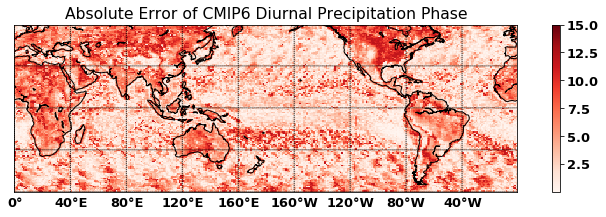

In [32]:
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'), vmin = -5, vmax = 5)
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('seismic_r'))
make_single_plot(cmips_err_ds['phase_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'), vmax = 15)
#                  vmin = 0, vmax = 3)
# plt.savefig(save_figs_dir + 'compare_models/' + 'phase_abs_error_spatial.png', dpi = 300)

# Taylor Plots

In [95]:
# gpm_std = df_gpm[field].std()
gpm_std =  circstd(df_gpm['phase_season'], low = 0.0, high = 24.0)
gpm_land_std = circstd(df_gpm_land['phase_season'], low = 0.0, high = 24.0)
gpm_water_std = circstd(df_gpm_water['phase_season'],low = 0.0, high = 24.0)

# # calculate obs ampl
# obs_water_std = hour_circstd(obs_water_df['phase_season'])
# obs_land_std = hour_circstd(obs_land_df['phase_season'])


In [249]:
# input_data_dir_rlut
# mean_fields_to_rel_path_map

{'rlut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/',
 'rsut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/',
 'pr': '/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/',
 'clt': '/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/'}

In [ ]:
# os.listdir(input_data_dir_rlut)
%run model_by_model_analysis_helper.py

In [39]:


%run model_by_model_analysis_helper.py

# tropics
# min_lat, max_lat = -30, 30
# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                        filter_by_lat = True,
#                        **{'min_lat': min_lat,
#                        'max_lat': max_lat})


# # tropics water
min_lat, max_lat = -60, 60
field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt', 'cltl', 'clth'],
                      mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
                      file_name = 'grid1_1985-01_2006-01_mean.nc',
                      filter_lat = True,
                      landsea_mask_df = df_land_sea,
                      landsea_bool = 0,
                       **{'min_lat': min_lat,
                          'max_lat': max_lat,
                          'absolute_value': False})
# subtropics
# min_lat, max_lat = 30, 60
# min_lat, max_lat = -30, 30

# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                        filter_lat = True,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': True})


# rr = _get_mean_field(field_name = 'rsut',
#                       data_dir = mean_fields_to_rel_path_map['rsut'],
#                       file_name = 'grid1_1985-01_2006-01_mean.nc',
#                       filter_lat = True,
#                       landsea_mask_df = df_land_sea,
#                       landsea_bool = 0,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': False})




# stats_kwargs = {'ecs_dict': cmip6_ecs, 'tcr_dict': cmip6_tcr, 
#      'rlut_dict': rlut_dict, 'rsut_dict': rsut_dict, 
#      'pr_dict': pr_dict, 'clt_dict': clt_dict}

In [17]:
# field_means_df

In [86]:
# ds_clt = xr.open_dataset(mean_fields_to_rel_path_map['clt'] + 'grid1_1985-01_2006-01_mean.nc')

In [283]:
%run model_by_model_analysis_helper.py




model_name  ecs  tcr
0      ACCESS-CM2  4.7  2.1
1   ACCESS-ESM1-5  3.9  2.0
2   AWI-CM-1-1-MR  3.2  2.0
3     BCC-CSM2-MR  3.0  1.7
4      CNRM-CM6-1  4.8  2.1
5   CNRM-CM6-1-HR  4.3  2.5
6     CNRM-ESM2-1  4.8  1.9
7         CanESM5  5.6  2.7
8       EC-Earth3  4.3  NaN
9   EC-Earth3-Veg  4.3  2.6
10       GFDL-CM4  3.9  2.1
11      GFDL-ESM4  2.6  1.6
12    GISS-E2-1-G  2.7  1.8
13   IPSL-CM6A-LR  4.6  2.3
14     KACE-1-0-G  4.5  1.4
15     MIROC-ES2L  2.7  1.6
16         MIROC6  2.6  1.6
17  MPI-ESM1-2-HR  3.0  1.7
18  MPI-ESM1-2-LR  3.0  1.8
19     MRI-ESM2-0  3.2  1.6
20          NESM3  4.7  2.7
21    SAM0-UNICON  3.7  2.3
22    UKESM1-0-LL  5.3  2.8

In [101]:
df_cmip6

mu_season  sigma_season  ampl_season  phase_season  \
lat   lon                                                          
-60.0 0.0    319.116305      0.000001    20.697814      0.352430   
      0.0    292.640777      0.000001    19.832092      4.407215   
      0.0    302.984901      0.000002    28.216164      1.270834   
      0.0    406.463446      0.000002    35.628208      3.733441   
      0.0    319.400805      0.000001    13.503056      0.559018   
...                 ...           ...          ...           ...   
 59.5 359.5  506.198672      0.000002    29.929645     23.523897   
      359.5  407.463676      0.000002    34.726626      3.113692   
      359.5  512.890478      0.000003    44.313239      4.061623   
      359.5  434.513560      0.000002    37.062054      2.207158   
      359.5  439.193347      0.000002    29.168619      3.366082   

             ampl_cov_season  phase_cov_season        model_name  \
lat   lon                                                          
-60.0 0.0       5.517608e-15          0.202726     MPI-ESM1-2-HR   
      0.0       3.060004e-15          0.026825          GFDL-CM4   
      0.0       3.830673e-15          0.015859       CNRM-ESM2-1   
      0.0       4.332492e-15          0.010475            MIROC6   
      0.0       7.255911e-15          0.169666      IPSL-CM6A-LR   
...                      ...               ...               ...   
 59.5 359.5     1.889427e-14          0.058180       SAM0-UNICON   
      359.5     1.043041e-14          0.038566        KACE-1-0-G   
      359.5     1.817834e-14          0.046553       UKESM1-0-LL   
      359.5     8.863222e-15          0.021398     MPI-ESM1-2-LR   
      359.5     1.203981e-14          0.074195  EC-Earth3-Veg-LR   

            cmip_identifier  land_sea_mask  
lat   lon                                   
-60.0 0.0             CMIP6              0  
      0.0             CMIP6              0  
      0.0             CMIP6              0  
      0.0             CMIP6              0  
      0.0             CMIP6              0  
...                     ...            ...  
 59.5 359.5           CMIP6              0  
      359.5           CMIP6              0  
      359.5           CMIP6              0  
      359.5           CMIP6              0  
      359.5           CMIP6              0  

[4492800 rows x 9 columns]

In [60]:
cmip_sens = cmip6_sensitivities.reset_index().rename({'index':'model_name'}, axis = 1)
cmip_means = field_means_df.reset_index().rename({'index':'model_name'}, axis = 1)
# merged_df = pd.merge(df_for_stats_water.reset_index(), cmip_sens,
#                     how = 'left',
#                     on = 'model_name')
merged_df = pd.merge(df_for_stats_water.reset_index(), cmip_means,
                    how = 'left',
                    on = 'model_name')

In [59]:
# corr_map_df

In [61]:
%%time
corr_map_df = pd.DataFrame()
for lat_ii in merged_df['lat'].unique():
    print(lat_ii)
    for lon_ii in merged_df['lon'].unique():
        grid_cell_df = merged_df[(merged_df['lat'] == lat_ii) & (merged_df['lon'] == lon_ii)]
        out_df_row = grid_cell_df.corr()['clt']
        out_df_row['lat'] = lat_ii
        out_df_row['lon'] = lon_ii
        
        corr_map_df = corr_map_df.append(out_df_row)
# res = merged_df[['lat','lon','phase_season', 'ecs', 'tcr']].groupby(['lat','lon']).corr()


-60.0
-59.5
-59.0
-58.5
-58.0
-57.5
-57.0
-56.5
-56.0
-55.5
-55.0
-54.5
-54.0
-53.5
-53.0
-52.5
-52.0
-51.5
-51.0
-50.5
-50.0
-49.5
-49.0
-48.5
-48.0
-47.5
-47.0
-46.5
-46.0
-45.5
-45.0
-44.5
-44.0
-43.5
-43.0
-42.5
-42.0
-41.5
-41.0
-40.5
-40.0
-39.5
-39.0
-38.5
-38.0
-37.5
-37.0
-36.5
-36.0
-35.5
-35.0
-34.5
-34.0
-33.5
-33.0
-32.5
-32.0
-31.5
-31.0
-30.5
-30.0
-29.5
-29.0
-28.5
-28.0
-27.5
-27.0
-26.5
-26.0
-25.5
-25.0
-24.5
-24.0
-23.5
-23.0
-22.5
-22.0
-21.5
-21.0
-20.5
-20.0
-19.5
-19.0
-18.5
-18.0
-17.5
-17.0
-16.5
-16.0
-15.5
-15.0
-14.5
-14.0
-13.5
-13.0
-12.5
-12.0
-11.5
-11.0
-10.5
-10.0
-9.5
-9.0
-8.5
-8.0
-7.5
-7.0
-6.5
-6.0
-5.5
-5.0
-4.5
-4.0
-3.5
-3.0
-2.5
-2.0
-1.5
-1.0
-0.5
0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5
20.0
20.5
21.0
21.5
22.0
22.5
23.0
23.5
24.0
24.5
25.0
25.5
26.0
26.5
27.0
27.5
28.0
28.5
29.0
29.5
30.0
30.5
31.0
31.5

In [62]:
corr_map_df = corr_map_df.set_index(['lat','lon'])

In [63]:
corr_map_ds = xr.Dataset.from_dataframe(corr_map_df)

In [252]:
corr_map_ds

<xarray.Dataset>
Dimensions:           (lat: 240, lon: 720)
Coordinates:
  * lat               (lat) float64 -60.0 -59.5 -59.0 -58.5 ... 58.5 59.0 59.5
  * lon               (lon) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Data variables:
    ampl_cov_season   (lat, lon) float64 0.06177 0.2422 ... 0.1192 -0.006319
    ampl_season       (lat, lon) float64 -0.08352 -0.1675 ... 0.1109 0.02215
    ecs               (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    land_sea_mask     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    mu_season         (lat, lon) float64 -0.3489 -0.3776 ... 0.01612 0.07941
    phase_cov_season  (lat, lon) float64 -0.1774 0.2274 0.1922 ... 0.1732 0.1259
    phase_season      (lat, lon) float64 -0.01287 -0.09937 ... 0.005215 0.08861
    sigma_season      (lat, lon) float64 -0.0974 -0.1348 ... 0.1285 0.02823
    tcr               (lat, lon) float64 0.7039 0.7039 0.7039 ... 0.7039 0.7039

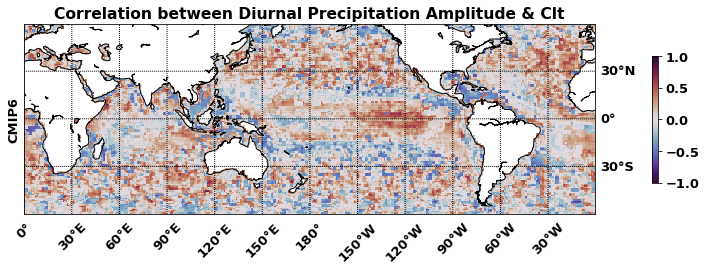

In [66]:
# corr_map_ds['phase_season'].plot.imshow()
fig = plt.figure(figsize = (10,8))
make_single_plot(corr_map_ds['phase_season'], 
                 title = r'Correlation between Diurnal Precipitation Amplitude & Clt',
                 ax = plt.gca(),
                 fig = fig,
                 ylabel = 'CMIP6', 
                 xticks_bool = True,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = -1, vmax = 1)
# plt.savefig(save_figs_dir + 'tapio_update_8_26/' + 'ampl_corr_ecs_map.png', dpi = 300)

In [72]:
ds_gpm

NameError: name 'ds_gpm' is not defined

In [98]:
corr_map_ds['phase_season'].where(ds_gpm['mu_season'] < 50).plot.imshow()


NameError: name 'ds_gpm' is not defined

In [87]:
# compute stats for all points
# df_for_stats[df_for_stats['ampl_season']> 0.001
%run model_by_model_analysis_helper.py
# model_error_stats_df= compute_stats(df_for_stats,
#                  df_for_stats_true,
#                  field = 'phase_season',
#                  agg_method = 'mode',
#                  error_stats = True,
#                  additional_stats = True,)                

model_error_stats_df_land = compute_stats(df_for_stats_land,
                 df_for_stats_true_land,
                 field = 'phase_season',
                 agg_method = 'mode',
                 additional_stats = True,)


### compute stats for land/water
model_error_stats_df_water = compute_stats(df_for_stats_water,
                 df_for_stats_true_water,
                 agg_method = 'mode',
                 field = 'phase_season',
                 additional_stats = True,)


# model_error_stats_df_water = compute_stats(filter_by_lat(df_for_stats_water, min_lat, max_lat),
#                  filter_by_lat(df_for_stats_true_water, min_lat, max_lat),
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

####### compute stats for given latitude range
# min_lat, max_lat = -60, 60
# # # # min_lat, max_lat = 30, 60
# # # # min_lat, max_lat = 0, 60

# # # # min_lat, max_lat = 30, 60
# absolute_values = False

# # # print(min_lat, max_lat)
# # df_for_stats_filt = filter_by_lat(df_for_stats, min_lat, max_lat, absolute_value=False)
# # df_for_stats_true_filt = filter_by_lat(df_for_stats_true, min_lat, max_lat, absolute_value=False)


# df_for_stats_filt_land = filter_by_lat(df_for_stats_land, min_lat, max_lat, absolute_value=absolute_values)
# df_for_stats_true_filt_land = filter_by_lat(df_for_stats_true_land, min_lat, max_lat, absolute_value=absolute_values)


# df_for_stats_filt_water = filter_by_lat(df_for_stats_water, min_lat, max_lat, absolute_value=absolute_values)
# df_for_stats_true_filt_water = filter_by_lat(df_for_stats_true_water, min_lat, max_lat, absolute_value=absolute_values)



# # model_error_stats_df = compute_stats(df_for_stats_filt,
# #                  df_for_stats_true_filt,
# #                  agg_method = 'mean',
# #                  field = 'phase_season',
# #                  additional_stats = True, 
# #                  **stats_kwargs)
                

    
    

# model_error_stats_df_water = compute_stats(df_for_stats_filt_water,
#                  df_for_stats_true_filt_water,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',)

# model_error_stats_df_land = compute_stats(df_for_stats_filt_land,
#                  df_for_stats_true_filt_land,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',)

In [311]:
# # tropics water
min_lat, max_lat = -30, -0
field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
                      mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
                      file_name = 'grid1_1985-01_2006-01_mean.nc',
                      filter_lat = True,
                      landsea_mask_df = df_land_sea,
                      landsea_bool = 0,
                       **{'min_lat': min_lat,
                          'max_lat': max_lat,
                          'absolute_value': False})

In [81]:

### select season
# season_ii = 'DJF'
# df_for_analysis = model_error_stats_df_water
# df_for_analysis = df_for_analysis.reset_index('season')
# df_for_analysis = df_for_analysis[df_for_analysis['season'] == season_ii]


### yearly mean
df_for_analysis = model_error_stats_df_water

merge_sensitivities = pd.merge(df_for_analysis, cmip5_sensitivities, 
         how = 'left',
         left_index = True, 
         right_index = True)
all_stats_df = pd.merge(merge_sensitivities, field_means_df,
         how = 'left',
         left_index = True, 
         right_index = True)

In [257]:
df_cmi

mu_season  sigma_season  ampl_season  phase_season  \
lat   lon                                                         
-60.0 0.0     0.000025      0.000001     0.000002      0.352430   
      0.0     0.000023      0.000001     0.000002      4.407215   
      0.0     0.000023      0.000002     0.000002      1.270834   
      0.0     0.000031      0.000002     0.000003      3.733441   
      0.0     0.000025      0.000001     0.000001      0.559018   
...                ...           ...          ...           ...   
 59.5 359.5   0.000039      0.000002     0.000002     23.523897   
      359.5   0.000031      0.000002     0.000003      3.113692   
      359.5   0.000040      0.000003     0.000003      4.061623   
      359.5   0.000034      0.000002     0.000003      2.207158   
      359.5   0.000034      0.000002     0.000002      3.366082   

             ampl_cov_season  phase_cov_season        model_name  \
lat   lon                                                          
-60.0 0.0       5.517608e-15          0.202726     MPI-ESM1-2-HR   
      0.0       3.060004e-15          0.026825          GFDL-CM4   
      0.0       3.830673e-15          0.015859       CNRM-ESM2-1   
      0.0       4.332492e-15          0.010475            MIROC6   
      0.0       7.255911e-15          0.169666      IPSL-CM6A-LR   
...                      ...               ...               ...   
 59.5 359.5     1.889427e-14          0.058180       SAM0-UNICON   
      359.5     1.043041e-14          0.038566        KACE-1-0-G   
      359.5     1.817834e-14          0.046553       UKESM1-0-LL   
      359.5     8.863222e-15          0.021398     MPI-ESM1-2-LR   
      359.5     1.203981e-14          0.074195  EC-Earth3-Veg-LR   

            cmip_identifier  land_sea_mask  
lat   lon                                   
-60.0 0.0             CMIP6              0  
      0.0             CMIP6              0  
      0.0             CMIP6              0  
      0.0             CMIP6              0  
      0.0             CMIP6              0  
...                     ...            ...  
 59.5 359.5           CMIP6              0  
      359.5           CMIP6              0  
      359.5           CMIP6              0  
      359.5           CMIP6              0  
      359.5           CMIP6              0  

[4492800 rows x 9 columns]

In [263]:
# df_cmip6_seasonal.index


In [40]:
%%time
%run model_by_model_analysis_helper.py


cmip6_stats_water, cmip6_stats_land = full_analysis(df_cmip6,
                    df_gpm,
                    cmip6_sensitivities,
                    field_means_df)

# cmip6_stats_water_winter, _ = full_analysis(df_cmip6_seasonal,
#                                             df_gpm_seasonal,
#                                             cmip6_sensitivities,
#                                             field_means_df,
#                                             min_lat = -30,
#                                             max_lat = 0)
# cmip6_stats_water_winter = cmip6_stats_water_winter[cmip6_stats_water_winter['season'] == 'JJA']


# cmip5_stats_water, cmip5_stats_land = full_analysis(df_cmip5,
#                     df_gpm,
#                     cmip5_sensitivities)

# cmip5_stats_water_summer, _ = full_analysis(df_cmip5_seasonal,
#                                             df_gpm_seasonal,
#                                             cmip5_sensitivities,
#                                             min_lat = 0,
#                                             max_lat = 60)
# cmip5_stats_water_summer = cmip5_stats_water_summer[cmip5_stats_water_summer['season'] == 'JJA']

/home/cchristo/proj_tapio/diurnal_research/model_by_model_analysis_helper.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_stats['ampl_season'] = df_for_stats['ampl_season'].apply(lambda x: x*FLUX_TO_MM_HR)
/home/cchristo/proj_tapio/diurnal_research/model_by_model_analysis_helper.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_stats['mu_season'] = df_for_stats['mu_season'].apply(lambda x: x*FLUX_TO_MM_HR)


CPU times: user 22.4 s, sys: 2.02 s, total: 24.5 s
Wall time: 6.56 s


In [25]:
# field_means_df


In [490]:
# cmip6_stats_water_summer
mode(cmip6_stats_land['phase_mean'].values)


ModeResult(mode=array([12.8]), count=array([2]))

In [491]:
mode(cmip5_stats_land['phase_mean'].values)

ModeResult(mode=array([11.6]), count=array([2]))

In [492]:
mode(df_gpm_land['phase_season'].round(1).values)

ModeResult(mode=array([19.2]), count=array([828]))

In [33]:
# save_fig_corr_heatmap_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/corr_heatmaps/CMIP6/'
save_fig_corr_heatmap_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/tapio_update_8_26/' 

## Make Correlation Heatmap

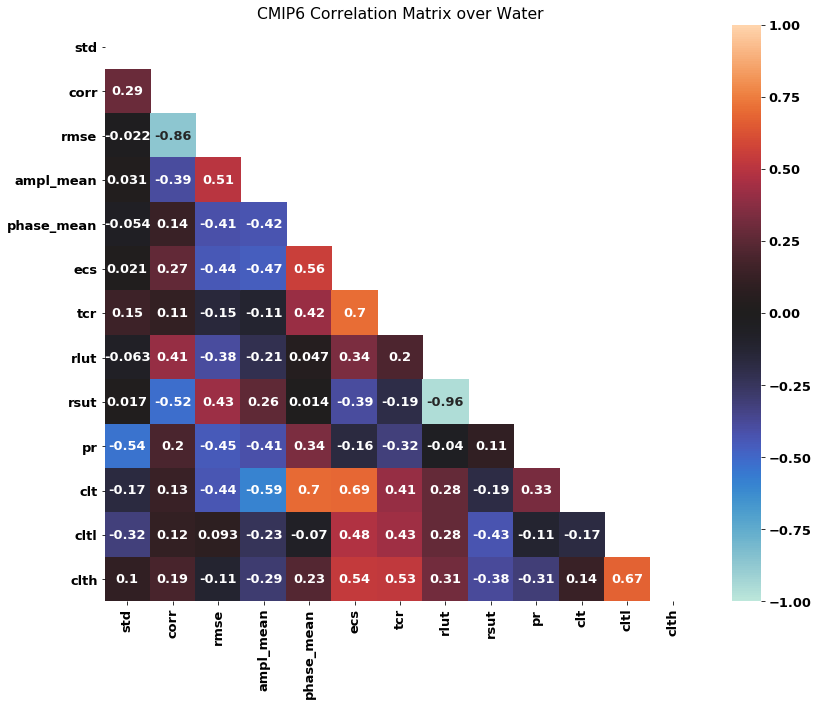

In [41]:

corr_mat_ds = cmip6_stats_water

plot_corr_matrix(corr_mat_ds, 
                 title = 'CMIP6 Correlation Matrix over Water')
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_mat_water_max_cloud_cover.png', dpi = 300)
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_mat_water_nh_all_djf.png', dpi = 300)

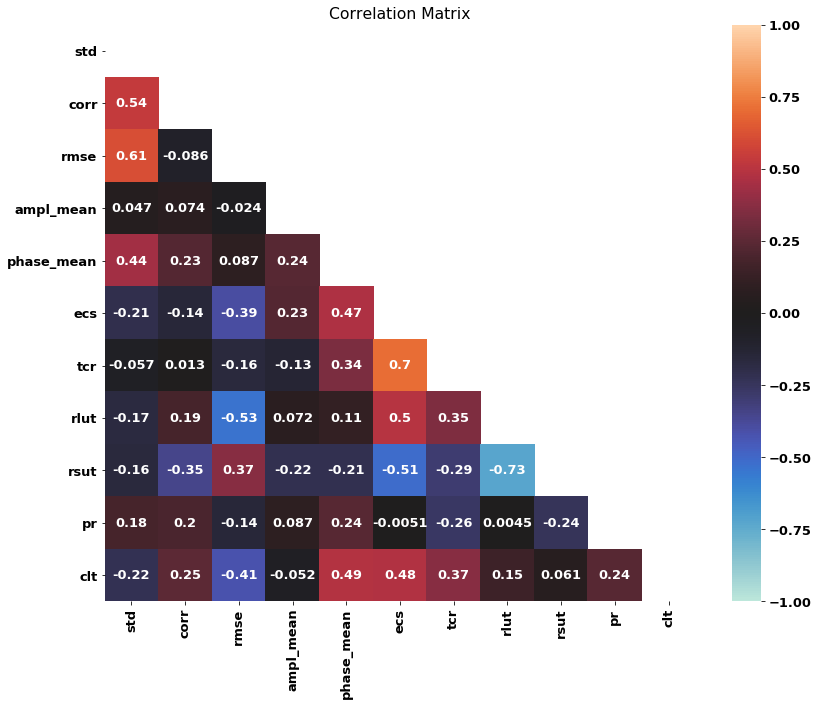

In [159]:
# model_error_stats_df #.reset_index('season')

corr_mat_ds = all_stats_df
# .drop(['IPSL-CM6A-LR']) #.drop(['BCC-CSM2-MR']) #.drop(['GFDL-ESM2M', 'MIROC5'])

# mes_df_season = model_error_stats_df.reset_index('season')
# mes_df_season = mes_df_season[mes_df_season['season'] == 'JJA']

# corr_mat_ds = mes_df_season

# plt.figure(figsize = (12,10))
# plt.title('Correlation Matrix for All Latitudes [Method: mode]')
# upper_tr_mask = np.triu(corr_mat_ds.corr())
# sns.heatmap(corr_mat_ds.corr(), annot = True, 
#             vmin = -1, vmax = 1, center = 0, fmt='.2g',
#             mask = upper_tr_mask)

# plt.tight_layout()
plot_corr_matrix(corr_mat_ds)
# plt.savefig(save_figs_dir + 'corr_heatmaps/CMIP6/' + 'land_and_water_poleward_of_35.png', dpi = 300)

In [94]:
# model_error_stats_df
# model_error_stats_df.sort_values('rmse')

In [42]:
def metric_scatter(df, x_field = 'phase_mean', 
                   y_field = 'ecs',
                   xlabel = 'Phase Mean [Hours]',
                   ylabel = 'ECS',
                   figsize = (8,5),
                   annotate_bool = True):
    plt.figure(figsize = figsize)
    # for mod_ii in model_error_stats_df.iterrows():
    model_list = list(df.index)
    for ii in range(len(df)):
        mod_ii = df.iloc[ii,:]
        xx,yy = mod_ii[x_field], mod_ii[y_field]
        if (not np.isnan(xx)) & (not np.isnan(yy)):
            plt.plot(xx, yy, 'o', label = str(ii) + ': ' + model_list[ii])
            plt.annotate(str(ii), (xx, yy), size = 9, weight = 'bold')
    plt.grid()
    plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5),prop={'size': 8})
    if xlabel:
        plt.xlabel(xlabel, weight = 'bold')
        
    if ylabel:
        plt.ylabel(ylabel, weight = 'bold')
    
    corr = df.corr()[x_field][y_field]
    print(corr)
    if annotate_bool:
        plt.annotate('Corr:' + '{:.3f}'.format(corr), 
                     xy=(0.75, 0.01), xycoords='axes fraction')


    plt.tight_layout()

-0.0413181292459667


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Phase Water')

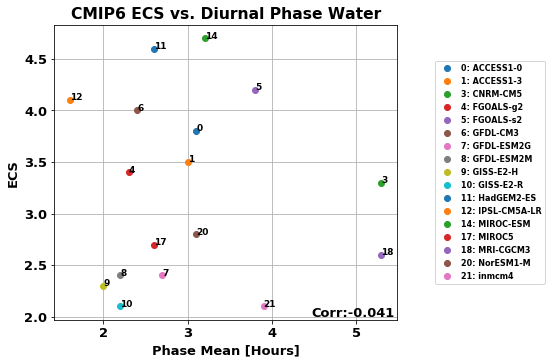

In [422]:

# metric_scatter(model_error_stats_df_land)
# plt.title('CMIP6 ECS vs. Diurnal Phase Land', weight = 'bold')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_land.png', dpi = 300)


metric_scatter(all_stats_df)
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_25n_25_s.png', dpi = 300)

# metric_scatter(model_error_stats_df_land, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Land', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_land.png', dpi = 300)


# metric_scatter(model_error_stats_df_water, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Water', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_water.png',  dpi = 300)



-0.0413181292459667


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Phase Water')

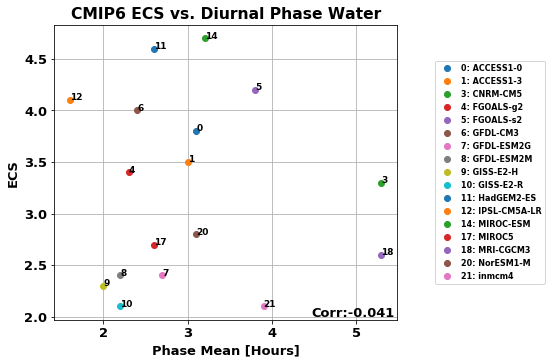

0.5610484646501726


Text(0.5, 1, 'CMIP6')

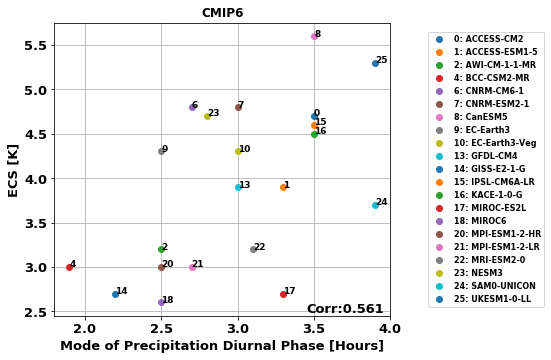

In [94]:
# plt.figure(figsize = (7,10))

metric_scatter(cmip6_stats_water,  
               x_field = 'phase_mean',  
               y_field = 'ecs',
               xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
               ylabel = 'ECS [K]',
               figsize = (8,5), 
               annotate_bool=True)
# plt.xticks(rotation=45)
plt.title('CMIP6', weight = 'bold', fontsize = 12)
# plt.savefig(save_figs_dir_paper + 'ecs_vs_phase_water_nh_summer.png', dpi = 300)
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_phase_ecs_water.png', dpi = 250)





# metric_scatter(cmip6_stats_water, 
#                x_field = 'phase_mean',  
#                y_field = 'ecs',
#                xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
#                ylabel = 'ECS [K]',
#                figsize = (8,5), 
#                annotate_bool=True)
# # plt.xticks(rotation=45)
# plt.title('CMIP6', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_new.png', dpi = 300)




0.23209140962986746


Text(0.5, 1, 'CMIP6')

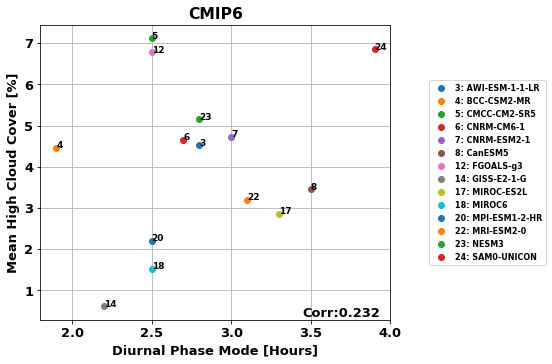

In [43]:
# sanity check modes
# mode_apply(df_cmip5[df_cmip5['model_name'] == 'GFDL-ESM2G'].round(1)['phase_season'])

metric_scatter(cmip6_stats_water,  
               y_field = 'clth', 
               x_field = 'phase_mean',
               xlabel = 'Diurnal Phase Mode [Hours]',
               ylabel = 'Mean High Cloud Cover [%]',)
plt.title('CMIP6', weight = 'bold')
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_phase_clth_water_max.png', dpi = 250)



-0.12287311062972195


Text(0.5, 1, 'CMIP6 Mean Outgoing Shortwave Radiation vs. Diurnal Amplitude')

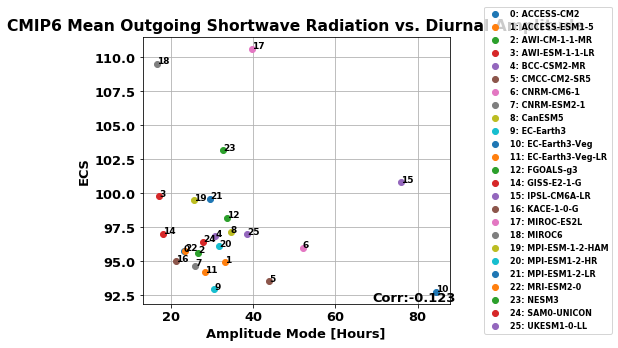

In [97]:
metric_scatter(cmip6_stats_water,  
               y_field = 'rsut', x_field = 'ampl_mean',
               xlabel = 'Amplitude Mode [Hours]')
plt.title('CMIP6 Mean Outgoing Shortwave Radiation vs. Diurnal Amplitude', weight = 'bold')
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)




In [248]:
# metric_scatter(model_error_stats_df,  y_field = 'rlut', x_field = 'rsut')
# plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)





0.6939125146384588


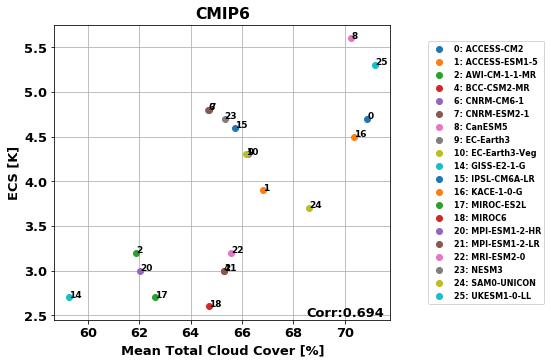

In [37]:
metric_scatter(cmip6_stats_water,  
               y_field = 'ecs', 
               x_field = 'clt',
               ylabel = 'ECS [K]',
               xlabel = 'Mean Total Cloud Cover [%]',)
plt.title('CMIP6', weight = 'bold')
plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_clt_ecs_water.png', dpi = 250)




# plt.savefig(save_figs_dir + 'diurnal_vs_climate/' + 'ecs_vs_tcr_cmip6.png',  dpi = 300)



In [38]:
# Create Taylor Diagram
# import taylorDiagram
# %%capture
%run taylorDiagram.py

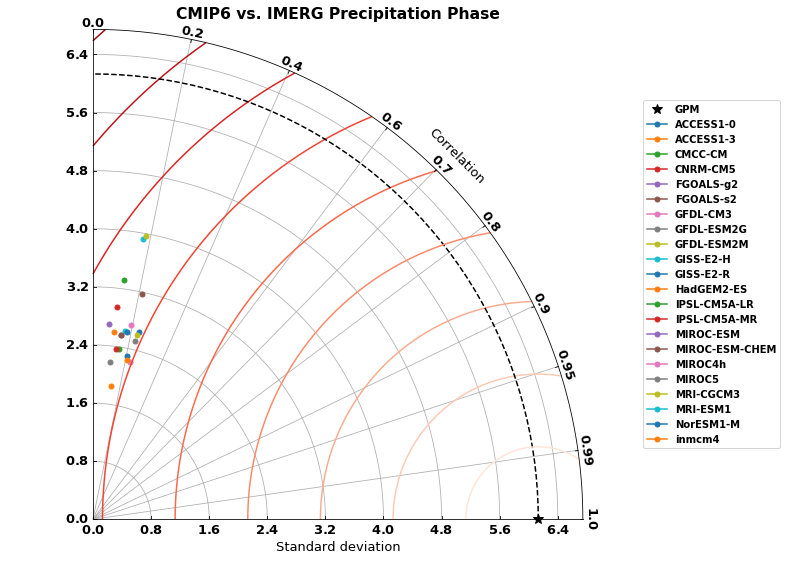

In [101]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_water.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_water.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_water.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP6 vs. IMERG Precipitation Phase', weight = 'bold')
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_water.png', dpi = 300)

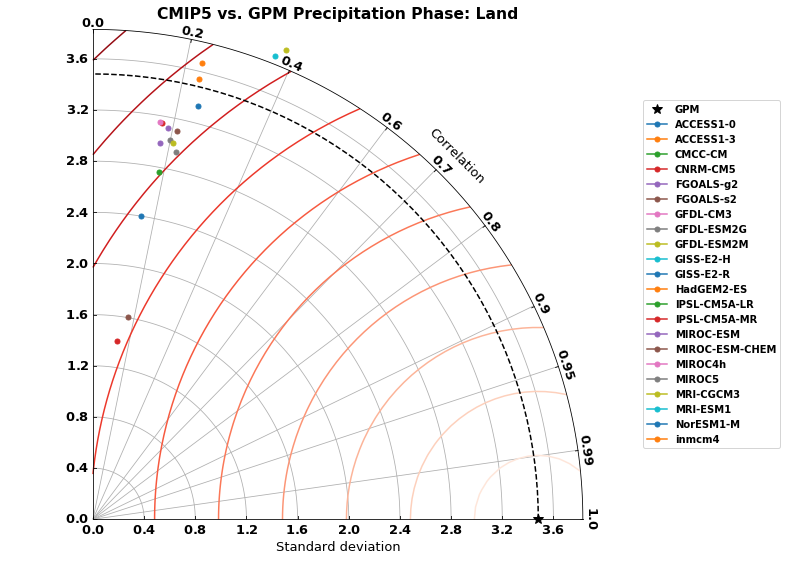

In [96]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_land_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_land.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_land.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_land.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP5 vs. GPM Precipitation Phase: Land', weight = 'bold')
plt.tight_layout()

# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_land.png', dpi = 300)

In [93]:
# mode_apply(df_for_stats_true_water['phase_season'])
# df_for_stats_true.plot(x = 'ampl_season', y = 'phase_season' , kind = 'scatter')
# sns.jointplot('ampl_season', 'phase_season', data = df_for_stats_true, 
#               kind = 'hex', xlim = [0, 0.2])
# _ = plt.hist2d(df_for_stats_true['ampl_season'], df_for_stats_true['phase_season'], bins = 300,
#               density = True, cmap = plt.get_cmap('gist_ncar'))
# plt.xlim([0, 0.2])
# plt.colorbar()

In [456]:
import importlib
# import PhaseDiagram
importlib.reload(phaseDiagram)

# %run phaseDiagram.py
%run model_by_model_analysis_helper.py




# make_phase_plot(model_error_stats_df_water,
#                 model_error_stats_df_land,
#                 df_for_stats_true_land, 
#                 df_for_stats_true_water,
#                )

ModuleNotFoundError: No module named 'PhaseDiagram'

Text(0.5, 1.05, 'Diurnal Phase [hr] & Amplitude [$\\frac{mm}{yr}$] for CMIP5 and IMERG')

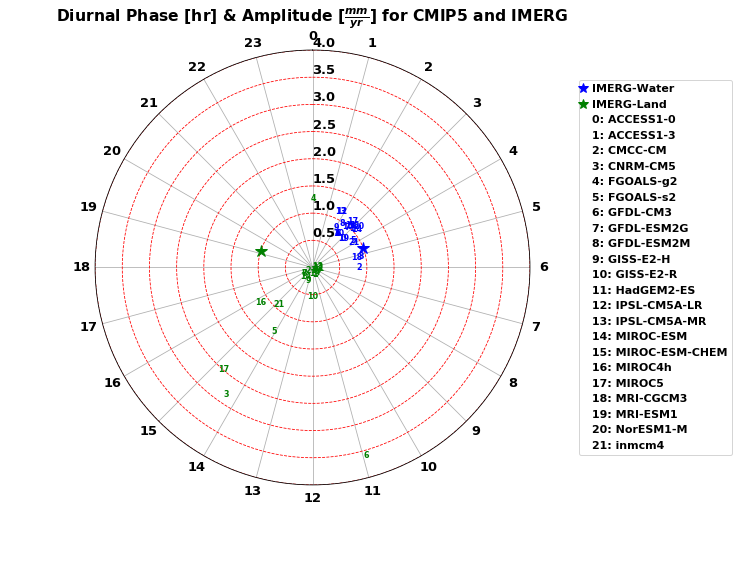

In [164]:
%run phaseDiagram.py

fig = plt.figure(figsize = (13,8))
# plt.title('Test')

markersize = 2
textsize = 8
normalize_ampl = True

ampl_unit_conversion_factor = MM_HR_TO_MM_YR
taylor_diag = PhaseDiagram(
                          fig = fig, 
                          label = 'IMERG', 
                          y_lim=(0, 4),
                          radial_label_pos = 0
                          )
taylor_diag.add_grid()

ampl_observed_water = mode_apply(df_for_stats_true_water['ampl_season'].round(4)* ampl_unit_conversion_factor)
ampl_observed_land = mode_apply(df_for_stats_true_land['ampl_season'].round(4)* ampl_unit_conversion_factor)

if normalize_ampl:
    ampl_to_plot_water = 1.0
    ampl_to_plot_land = 1.0
else:
    ampl_to_plot_water = ampl_observed_water
    ampl_to_plot_land = ampl_observed_land
    
taylor_diag.add_sample(phase = mode_apply(df_for_stats_true_water['phase_season'].round(1)), 
                           ampl = ampl_to_plot_water, 
                           marker = '*', 
                           c = 'b',
                           label = 'IMERG-Water', 
                           markersize = 13)

taylor_diag.add_sample(phase = mode_apply(df_for_stats_true_land['phase_season'].round(1)), 
                           ampl = ampl_to_plot_land, 
                           marker = '*', 
                           c = 'g',
                           label = 'IMERG-Land', 
                           markersize = 13)


## Plot model phase/ampl over water
model_list = list(model_error_stats_df_water.index)
for model_name_i in range(len(model_list)):

    phase_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['ampl_mean'] * ampl_unit_conversion_factor

    if normalize_ampl:
        ampl_i = ampl_i/ampl_observed_water
    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None,
                           linestyle = None,
                           c = 'b',
                           label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           markersize = markersize)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         label = str(model_name_i) + ': ' + model_list[model_name_i], 
                         c = 'b',
                         size = textsize,
                         weight = 'bold')
    
## Plot model phase/ampl over land
for model_name_i in range(len(model_list)):
    phase_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['ampl_mean'] * ampl_unit_conversion_factor
    
    if normalize_ampl:
        ampl_i = ampl_i/ampl_observed_land
        
    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None, 
                           c = 'g',
                           linestyle = None,
#                            label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           label = None,
                           markersize = markersize)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         c = 'g',
                         size = textsize,
                         weight = 'bold')



leg = plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 11}, handlelength = 0, markerscale = 0.8)

    
plt.title(r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{yr}$] for CMIP5 and IMERG', weight = 'bold')
# plt.title(r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{hr}$] : CMIP6 vs. GPM Poleward of 35 N/S (Method: mode)', weight = 'bold')
# plt.tight_layout()

# plt.savefig(save_figs_dir + 'phase_ampl_plots/CMIP6/' + 'all_cmip6_land_water_pw_35NS.png', dpi = 300)

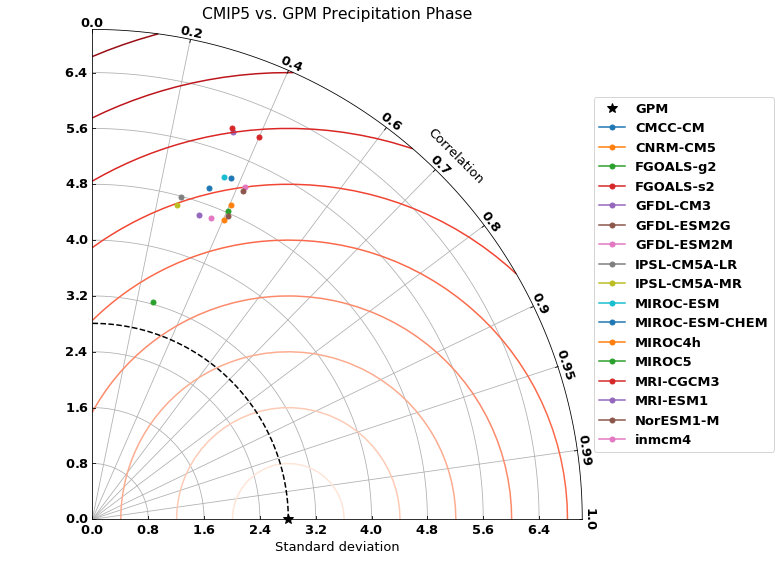

In [165]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM',
                                           srange=(0, 2.5))
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats.keys()):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats[model_name][0], 
                           corrcoef = model_error_stats[model_name][1], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1,0.5))

plt.title('CMIP5 vs. GPM Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5.png', dpi = 300)